In [1]:
#### %matplotlib inline
from dataloader import *
from plotter import *
from neural_net_tf1 import *
from scripts import *
import tensorflow as tf
print("tensorflow version", tf.__version__)
parula_map=get_parula_map()

tensorflow version 2.0.0


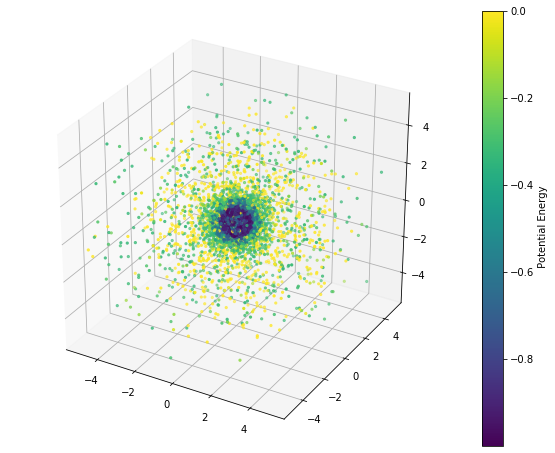

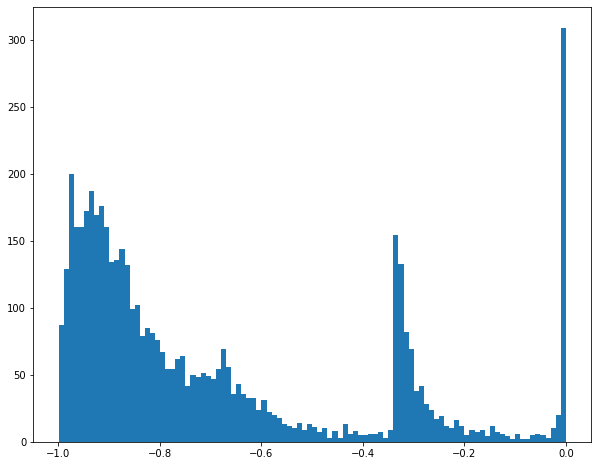

In [2]:
#load dataset
features = load_features_2d("../data/3P_CENTERED_COORDINATES.txt", 3)
labels = load_labels("../data/3P_T018_POTENTIALS.txt", 1)
x = []
y = []
z = []
c = []
for i in range(len(features)):
    for j in range(0, len(features[i]), 3):
        x.append(features[i][j+0])
        y.append(features[i][j+1])  
        z.append(features[i][j+2])
        c.append(labels[i])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
a = ax.scatter(x, y, z, s=5, c=np.array(c).flatten())
fig.colorbar(a, label=' Potential Energy')
plot_histogram(labels)
plt.show()

In [3]:
#define Structure of neural net
structure = [9, 11, 6, 6, 2, 1]
activations = ['tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh']
model_dir = "../models/TransRot0.18_3.ckpt"

#initialize neural network and train
nn = NEURAL_NET(3, structure, activations)
nn.learning_rate = 0.5




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






INFO:tensorflow:Restoring parameters from ../models/TransRot0.18_3.ckpt
INFO:tensorflow:Restoring parameters from ../models/TransRot0.18_3.ckpt


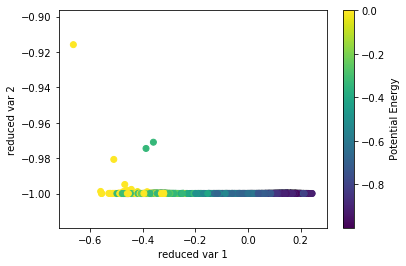

In [4]:
reduced_space = nn.get_reduced_space(features, model_dir)
predicted_potentials = nn.get_output_space(features, model_dir)
fig = plt.figure()
ax = fig.add_subplot(111)
a = ax.scatter(reduced_space[:, 0], reduced_space[:, 1], c=np.array(labels).flatten())
ax.set_xlabel('reduced var 1')
ax.set_ylabel('reduced var 2')
plt.style.use('seaborn-deep')
fig.colorbar(a, label=' Potential Energy')
plt.show()

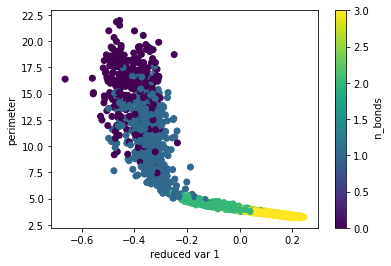

In [5]:
#calculating radius of gyration
RoG = np.zeros(len(features))
for i in range(len(features)):
    particles = np.reshape(features[i], [3, 3])
    for j in range(len(particles)):
        RoG[i] += np.linalg.norm(particles[j])/3.0
        
#extract some information from the feature space 
side_length_space = [] #side lengths between each particles
perimeter = [] #side lengths between each particles
n_bonds = np.zeros(len(features)) #number of bonds in the structure
cut_off_distance = 1.55 #sigma  
for i in range(len(features)):
    side_length_space.append([])
    particles = np.reshape(features[i], [3, 3])
    side_length_space[i] = [np.linalg.norm(particles[0]-particles[1]),
                            np.linalg.norm(particles[1]-particles[2]),
                            np.linalg.norm(particles[0]-particles[2])]   
    perimeter.append(np.sum(side_length_space[i]))
    b = 0
    if side_length_space[i][0] < cut_off_distance:
        n_bonds[i] += 1
    if side_length_space[i][1] < cut_off_distance:
        n_bonds[i] += 1
    if side_length_space[i][2] < cut_off_distance:
        n_bonds[i] += 1
fig = plt.figure()
ax = fig.add_subplot(111)
a = ax.scatter(reduced_space[:, 0], perimeter, c=np.array(n_bonds).flatten())
ax.set_xlabel('reduced var 1')
ax.set_ylabel('perimeter')
fig.colorbar(a, label=' n_bonds')
#plot_2d(n_bonds, labels)

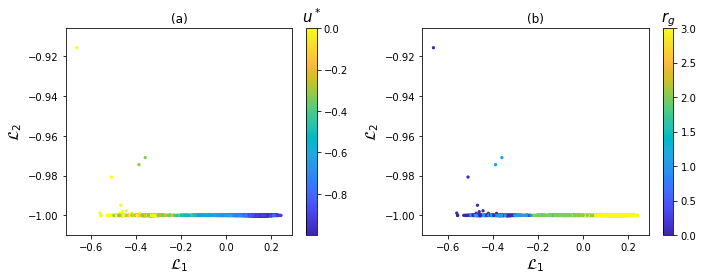

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
a1=axs[0].scatter(reduced_space[:, 0], reduced_space[:, 1], c=np.array(labels).flatten(), s=5, cmap=parula_map)
axs[0].set_title('(a)')
a2=axs[1].scatter(reduced_space[:,0], reduced_space[:,1], c=n_bonds, s=5, cmap=parula_map)
axs[1].set_title('(b)')

c1 = plt.colorbar(a1, ax=axs[0])
c2 = plt.colorbar(a2, ax=axs[1])

c1.ax.set_title('$u^*$', fontname='serif', fontsize=15)
c2.ax.set_title('$r_g$', fontname='serif', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel('$\mathcal{L}_1$', fontname='sans serif', fontsize=15)
    ax.set_ylabel('$\mathcal{L}_2$', fontname='sans serif', fontsize=15)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
plt.savefig("3p_nn.png")